# Install and import packages

In [1]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.2/257.2 kB 9.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import requests
import numpy as np
from google.colab import files
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playbyplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, accuracy_score
from sklearn import preprocessing
from statsmodels.nonparametric.smoothers_lowess import lowess


# Retry Wrapper 
To prevent API Timeout



In [2]:
def retry(func, retries=3):
    def retry_wrapper(*args, **kwargs):
        attempts = 0
        while attempts < retries:
            try:
                return func(*args, **kwargs)
            except requests.exceptions.RequestException as e:
                print(e)
                time.sleep(30)
                attempts += 1

    return retry_wrapper

# Get all games from 2007-2022

In [ ]:
@retry
def get_games(year):
    second_year = int(year[2:]) + 1
    season = str(year) + '-' + str(second_year)

    nba_teams = teams.get_teams()
    team_ids = [team['id'] for team in nba_teams]

    total_games = []
    for team_id in team_ids:
      # Get regular season games
      gamefinder = leaguegamefinder.LeagueGameFinder(
          season_nullable=season,
          team_id_nullable=team_id,
          season_type_nullable=['Regular Season']
      )
      games = gamefinder.get_data_frames()[0]
      total_games.append(games)
      # Get playoff games
      gamefinder = leaguegamefinder.LeagueGameFinder(
          season_nullable=season,
          team_id_nullable=team_id,
          season_type_nullable=['Playoffs']
      )
      games = gamefinder.get_data_frames()[0]
      total_games.append(games)
      time.sleep(.8)

    return pd.concat(total_games)

In [ ]:
games = []
year = '2007'
for i in range(15):
  games_from_year = get_games(year)
  games_from_year = games_from_year.sort_values('GAME_ID').drop_duplicates('GAME_ID')
  games.append(games_from_year)
  year = str(int(year)+1) 

all_games = pd.concat(games)
print(all_games)

# Get data from play-by-play api for given game

In [3]:
@retry
def get_data_from_pbp(game):
  # Get play by play data
  pbp = playbyplay.PlayByPlay(game["GAME_ID"]).get_data_frames()[0]

  # Get desired data for model training. Setting up columns GAME_ID, AWAY_SCORE, HOME_SCORE, SCORE_MARGIN, HOME_WIN, OT 
  res = pd.DataFrame()
  res['GAME_ID'] = pbp["GAME_ID"].astype(str)
  res['SCORE'] = pbp['SCORE'].copy()

  # Edit SCORE to eliminate empty scores
  prev_score = '0 - 0'
  for i in range(len(res)):
    play = res.iloc[[i]]
    if res.loc[i,'SCORE'] == None:
      res.loc[i,'SCORE'] = prev_score
    else:
      prev_score = res.loc[i,'SCORE']
    
  # Split SCORE into AWAY_SCORE and HOME_SCORE
  res[['AWAY_SCORE', 'HOME_SCORE']] = res['SCORE'].str.split('-', expand=True).astype(int)
  res.drop('SCORE', axis=1, inplace=True)

  # Set up SCORE_MARGIN to remove 'TIE' and None values
  res['SCORE_MARGIN'] = pbp['SCOREMARGIN'].copy()
  prev_margin = '0'
  for i in range(len(res)):
    play = res.iloc[[i]]
    if res.loc[i,'SCORE_MARGIN'] == None:
      res.loc[i,'SCORE_MARGIN'] = prev_margin
    elif res.loc[i,'SCORE_MARGIN'] == 'TIE':
      res.loc[i,'SCORE_MARGIN'] = '0'
      prev_margin = '0'
    else:
      prev_margin = res.loc[i,'SCORE_MARGIN']
  res['SCORE_MARGIN'] = res['SCORE_MARGIN'].astype(int)

  # Set up HOME_WIN based on SCOREMARGIN
  res['HOME_WIN'] = 1 if int(pbp.tail(1)['SCOREMARGIN'].values[0]) > 0 else 0
  res['OT'] = 0

  # lambda function that converts the PCTIMESTRING to seconds using datetime
  time_to_seconds = lambda x: datetime.datetime.strptime(x, '%M:%S').minute * 60 + datetime.datetime.strptime(x, '%M:%S').second
  res['TIME_REMAINING'] = ((4 - pbp['PERIOD']) *12*60) + pbp['PCTIMESTRING'].apply(time_to_seconds)

  # Handling time remaining for overtime
  res.loc[res['TIME_REMAINING'] < 0, 'OT'] = 1
  res.loc[res['TIME_REMAINING'] < 0, 'TIME_REMAINING'] = pbp['PCTIMESTRING'].apply(time_to_seconds)

  return res


# Create Data Set

In [ ]:
frames = []
for i in range(len(all_games)):
  data = get_data_from_pbp(all_games.iloc[[i]])
  frames.append(data)
  time.sleep(.8)

all_game_data_set = pd.concat(frames).reset_index(drop=True)
print(all_game_data_set)

# Import Existing Data Set

In [30]:
all_game_data_set = pd.read_csv('data_set.csv')

flipped_data_set = pd.read_csv('data_set.csv')
flipped_data_set.loc[flipped_data_set['HOME_WIN'] == 0, 'HOME_WIN'] = 2
flipped_data_set.loc[flipped_data_set['HOME_WIN'] == 1, 'HOME_WIN'] = 0
flipped_data_set.loc[flipped_data_set['HOME_WIN'] == 2, 'HOME_WIN'] = 1
flipped_data_set.rename(columns={'HOME_SCORE':'TEMP'}, inplace=True)
flipped_data_set.rename(columns={'AWAY_SCORE':'HOME_SCORE'}, inplace=True)
flipped_data_set.rename(columns={'TEMP':'AWAY_SCORE'}, inplace=True)
flipped_data_set['SCORE_MARGIN'] = flipped_data_set['SCORE_MARGIN']*-1

data_set = []
data_set.append(all_game_data_set)
data_set.append(flipped_data_set)
data_set = pd.concat(data_set)
print(data_set)

          GAME_ID  AWAY_SCORE  HOME_SCORE  SCORE_MARGIN  HOME_WIN  OT  \
0        20900001           0           0             0         0   0   
1        20900001           0           0             0         0   0   
2        20900001           0           2             2         0   0   
3        20900001           0           2             2         0   0   
4        20900001           0           2             2         0   0   
...           ...         ...         ...           ...       ...  ..   
7561669  42100406          90         103            13         1   0   
7561670  42100406          90         103            13         1   0   
7561671  42100406          90         103            13         1   0   
7561672  42100406          90         103            13         1   0   
7561673  42100406          90         103            13         1   0   

         TIME_REMAINING  
0                  2880  
1                  2880  
2                  2851  
3                  

In [31]:
q1 = data_set.loc[(data_set['TIME_REMAINING'] >= 2160) & (data_set['TIME_REMAINING'] <= 2880)]
q2 = data_set.loc[(data_set['TIME_REMAINING'] >= 1440) & (data_set['TIME_REMAINING'] <= 2160)]
q3 = data_set.loc[(data_set['TIME_REMAINING'] >= 720) & (data_set['TIME_REMAINING'] <= 1440)]
q4 = data_set.loc[(data_set['TIME_REMAINING'] >= 0) & (data_set['TIME_REMAINING'] <= 720) & (data_set['OT'] == 0)]
ot = data_set.loc[data_set['OT'] == 1]

# Split training and testing data for each quarter

In [32]:
q1_X_train, q1_X_test, q1_y_train, q1_y_test = train_test_split(q1[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]], q1['HOME_WIN'], test_size=0.20, random_state=16)
q2_X_train, q2_X_test, q2_y_train, q2_y_test = train_test_split(q2[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]], q2['HOME_WIN'], test_size=0.20, random_state=16)
q3_X_train, q3_X_test, q3_y_train, q3_y_test = train_test_split(q3[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]], q3['HOME_WIN'], test_size=0.20, random_state=16)
q4_X_train, q4_X_test, q4_y_train, q4_y_test = train_test_split(q4[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]], q4['HOME_WIN'], test_size=0.20, random_state=16)
ot_X_train, ot_X_test, ot_y_train, ot_y_test = train_test_split(ot[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]], ot['HOME_WIN'], test_size=0.20, random_state=16)

# Train model for each quarter

In [33]:
q1_model = LogisticRegression(solver='liblinear', random_state=0).fit(q1_X_train, q1_y_train)
q2_model = LogisticRegression(solver='liblinear', random_state=0).fit(q2_X_train, q2_y_train)
q3_model = LogisticRegression(solver='liblinear', random_state=0).fit(q3_X_train, q3_y_train)
q4_model = LogisticRegression(solver='liblinear', random_state=0).fit(q4_X_train, q4_y_train)
ot_model = LogisticRegression(solver='liblinear', random_state=0).fit(ot_X_train, ot_y_train)

# Score model

In [34]:
print(q1_model.score(q1_X_test,q1_y_test))
print(q2_model.score(q2_X_test,q2_y_test))
print(q3_model.score(q3_X_test,q3_y_test))
print(q4_model.score(q4_X_test,q4_y_test))
print(ot_model.score(ot_X_test,ot_y_test))

0.6018203788184623
0.6900843940337021
0.770516288322053
0.8731127461137294
0.7584987543196978


# Get an example game

In [35]:
nba_teams = teams.get_teams()
team = [team for team in nba_teams if team['abbreviation'] == 'LAL'][0]
team_id = team['id']
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)

games = gamefinder.get_data_frames()[0]
games = games[games.SEASON_ID.str[-4:] == '2010']
games = games[games.MATCHUP.str.contains('HOU')]
g = games.sort_values('GAME_DATE').iloc[0]
pbp = playbyplay.PlayByPlay(g["GAME_ID"]).get_data_frames()[0]
t = get_data_from_pbp(g)

t.drop('HOME_WIN', axis=1, inplace=True)
t.drop('GAME_ID', axis=1, inplace=True)

q1_t = t.loc[(t['TIME_REMAINING'] >= 2160) & (t['TIME_REMAINING'] <= 2880)]
q2_t = t.loc[(t['TIME_REMAINING'] >= 1440) & (t['TIME_REMAINING'] <= 2160)]
q3_t = t.loc[(t['TIME_REMAINING'] >= 720) & (t['TIME_REMAINING'] <= 1440)]
q4_t = t.loc[(t['TIME_REMAINING'] >= 0) & (t['TIME_REMAINING'] <= 720) & (t['OT'] == 0)]
ot_t = t.loc[t['OT'] == 1]


# Get regular predictions for example game

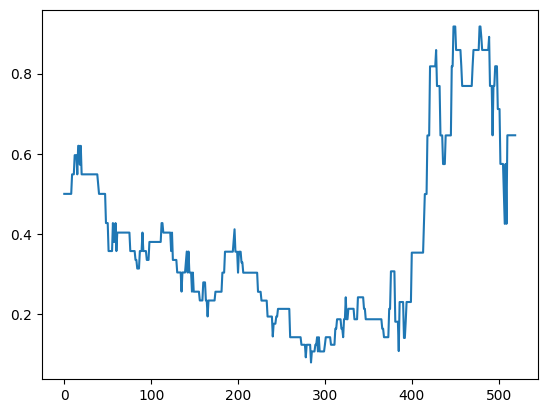

In [36]:
q1_p = q1_model.predict_proba(q1_t[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]])
q2_p = q2_model.predict_proba(q2_t[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]])
q3_p = q3_model.predict_proba(q3_t[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]])
q4_p = q4_model.predict_proba(q4_t[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]])
predictions = np.concatenate((q1_p, q2_p, q3_p, q4_p), axis=0)
if len(ot_t) > 0:
  ot_t = ot_t.values
  ot_p = ot_model.predict_proba(ot_t[["TIME_REMAINING", "HOME_SCORE", "AWAY_SCORE", "SCORE_MARGIN", "OT"]])
  predictions = np.concatenate((predictions,ot_p), axis=0)

plt.plot(predictions[:,1])
plt.show()


# Get smoothed predictions via lowess for example game

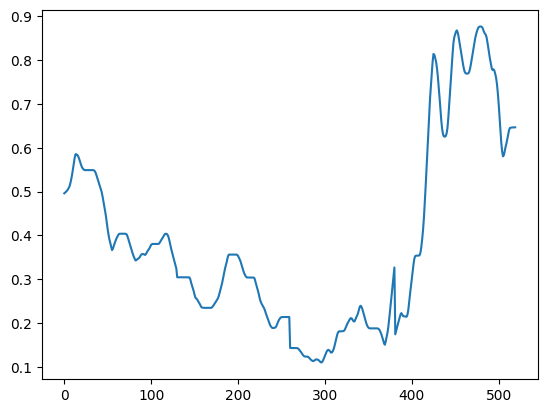

In [37]:
frac_value = 0.1
smoothed_q1_p = lowess(q1_p[:,1], np.arange(len(q1_p[:,1])), frac=frac_value)
smoothed_q2_p = lowess(q2_p[:,1], np.arange(len(q2_p[:,1])), frac=frac_value)
smoothed_q3_p = lowess(q3_p[:,1], np.arange(len(q3_p[:,1])), frac=frac_value)
smoothed_q4_p = lowess(q4_p[:,1], np.arange(len(q4_p[:,1])), frac=frac_value)

smoothed_predictions = np.concatenate((smoothed_q1_p[:,1], smoothed_q2_p[:,1], smoothed_q3_p[:,1], smoothed_q4_p[:,1]), axis=0)
if len(ot_t) > 0:
  smoothed_ot_p = lowess(ot_p[:,1], np.arange(len(ot_p[:,1])), frac=frac_value)
  smoothed_ot_p = smoothed_ot_p[:,1]
  smoothed_predictions = np.concatenate((smoothed_predictions,smoothed_ot_p), axis=0)

plt.plot(smoothed_predictions)
plt.show()

# Generate classifcation report 

The intercept b0=  [4.85562599e-05]
The coefficient b1=  [[ 1.18947777e-04  5.38322843e-02 -5.22139412e-02  1.06046226e-01
  -3.23930847e-05]]
Prediction Rates=  [[0.73152394 0.26847606]
 [0.38422375 0.61577625]
 [0.37709547 0.62290453]
 ...
 [0.15227342 0.84772658]
 [0.84926058 0.15073942]
 [0.4093873  0.5906127 ]]
The score=  0.7435860813999006


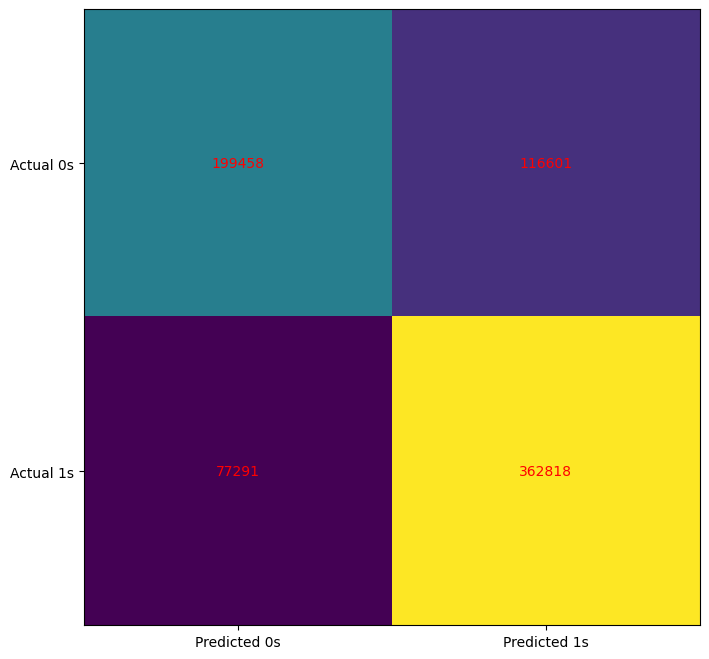

              precision    recall  f1-score   support

           0       0.72      0.63      0.67    316059
           1       0.76      0.82      0.79    440109

    accuracy                           0.74    756168
   macro avg       0.74      0.73      0.73    756168
weighted avg       0.74      0.74      0.74    756168



In [ ]:
cm = confusion_matrix(y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print(classification_report(y_test, model.predict(X_test)))


# Export models

In [38]:
filename = 'q1_model.sav'
pickle.dump(q1_model, open(filename, 'wb'))
files.download('q1_model.sav')
filename2 = 'q2_model.sav'
pickle.dump(q2_model, open(filename2, 'wb'))
files.download('q2_model.sav')
filename3 = 'q3_model.sav'
pickle.dump(q3_model, open(filename3, 'wb'))
files.download('q3_model.sav')
filename4 = 'q4_model.sav'
pickle.dump(q4_model, open(filename4, 'wb'))
files.download('q4_model.sav')
filename5 = 'ot_model.sav'
pickle.dump(ot_model, open(filename5, 'wb'))
files.download('ot_model.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>